In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# modflow utility 
import flopy
import flopy.utils.binaryfile as bf


In [2]:

## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'CosumnesRiverRecharge':
    git_dir = os.path.dirname(git_dir)
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

fig_dir = box_dir+'figures/'
data_dir = box_dir+'data_output/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [4]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/'
model_ws = loadpth+'flood_depth_analysis'

In [5]:
nrow = 100
ncol = 230
nlay = 1
delr = 200
delc = 200

m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
                          version = 'mfnwt', model_ws=model_ws)
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
#                           version = 'mf2005', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
#                                xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
#                               nper = 1, perlen=perlen, nstp=nstp, steady = steady,
#                               start_datetime = strt_date
                              )
xll, yll = 645500.0, 4227700.0
m.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=52.9, epsg=32610)



In [6]:
# a 10 m grid is most likely unneccessary if I can use rasters directly instead
# m.modelgrid.write_shapefile(gwfm_dir+'/DIS_data/grid_10m/grid_10m.shp')

In [7]:
# burn river shapefile into the 10 meter dem and then read it out to find the cells where it is
from flopy.utils import Raster
# Full size dem of northern sac valley
raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/modeldomain_10m_transformed.tif"

# rio10_utm = Raster.load(raster_name)
rio10_utm = rasterio.open(raster_name)
dem_10m = rio10_utm.read((1,))

In [8]:
# grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
# load sacramento river, creeks
rivers = gpd.read_file(gwfm_dir+'/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp')
cr = gpd.overlay(rivers.loc[rivers.GNIS_Name=='Cosumnes River'].to_crs('epsg:32610'), m_domain)

C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


In [9]:
from shapely.geometry import MultiLineString, LineString, Point, shape, mapping
from shapely.ops import linemerge
import fiona

cr_line = MultiLineString(cr.geometry.values)

In [10]:
buf_sfr = grid_sfr.copy()
setbacks = np.arange(0, 3400,200)
str_setbacks = np.zeros((len(setbacks), nrow, ncol))
# str_setbacks_local = np.zeros((len(setbacks),m.dis.nrow,m.dis.ncol))

# grid_sfr.plot()
for n in np.arange(0,len(setbacks)):
    buf_sfr.geometry = grid_sfr.buffer(setbacks[n])
    grid_sfr_buf = gpd.sjoin(grid_p,buf_sfr, how='right', lsuffix = 'grid', rsuffix = 'sfr',op='within')
    grid_sfr_buf = grid_sfr_buf.drop_duplicates('node_x')
    # clip to local setback sites
#     grid_sfr_buf_clipped = gpd.sjoin(grid_sfr_buf,local_setback, op='intersects',how='right')
    # individually identify local setback sites in arrays
#     for t in np.arange(0,3):
#         clip_vals = grid_sfr_buf_clipped.loc[grid_sfr_buf_clipped.id==t+1,:]
#         str_setbacks_local[n,clip_vals.row_x.values-1,clip_vals.column_x.values-1] = t+1
    str_setbacks[n, grid_sfr_buf.row_x.values-1,grid_sfr_buf.column_x.values-1] = 1


### Parallel XS

In [11]:


geom = shape(cr_line)

# # length of the LineString
length = int(geom.length)
sfr_sp = gpd.GeoDataFrame(pd.DataFrame(np.zeros((length,1)),columns=['id']))
sfr_sp['geometry'] = shapely.geometry.Point(0,0)
# enumerate keeps track of the count in addition to the object being iterated on
for i, distance in enumerate(range(0, length, 1)):
    point = geom.interpolate(distance)
    sfr_sp.loc[i,'geometry'] = point
    sfr_sp.loc[i,'id'] = i

In [12]:
sfr_sp['Easting'] = sfr_sp.geometry.x.values
sfr_sp['Northing'] = sfr_sp.geometry.y.values

point = sfr_sp.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    sfr_sp['z_ft'] = [sample[0] for sample in src.sample(point)]
    
sfr_sp['z_m'] = sfr_sp.loc[:,'z_ft']*0.3048


Find XS every 1000 meters avoids too much overlap in XS,  after calculating depth there is some discontinuity but WSE is uniform with slope, so the numebr could be reduced to 2000m which would also aid muskingum-cunge routing requirements (coarser time step allowed).   
I also realized that I should simplify the river feature to linearize it and avoid XS occuring on oddities where there is a large turn in the channel for a short distance. Adding a 500m tolerance simplify additionally reduces overlap and produces good XS locations/angles.

In [13]:
geom = linemerge(cr.geometry.values)
# tolerance is distance which simplified points can be from the original
geom = geom.simplify(500)

# how often to interpolate a point, 200 m matches model grid
dline = 2000
dline_long = np.copy(dline)
# # length of the LineString
length = int(geom.length)
# max width needed is 3200 m +100m from original channel + 5 to allow full 3200 both direction
xs_width = 3305*2

num_xs = np.floor(length/dline).astype(int)
transects = pd.DataFrame(np.zeros((num_xs,1)), columns = ['line'])
transects['geometry'] = LineString([(0,0),(0,1)]) #initiate LineString geometry column


for i, distance in enumerate(range(0, int(length), dline)):
    short_line = LineString([geom.interpolate(distance),geom.interpolate(distance+dline)])
    geom_left = short_line.parallel_offset(xs_width/2,'left', resolution = 32, join_style = 2)
    geom_right = short_line.parallel_offset(xs_width/2,'right', resolution = 32, join_style = 2)
    perp_line = LineString([geom_left.boundary[1], geom_right.boundary[0]])
    transects.loc[i,'geometry'] = perp_line

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51496\2947585350.py:22: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  perp_line = LineString([geom_left.boundary[1], geom_right.boundary[0]])


C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\io\file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\io\file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\ajcal

<AxesSubplot: >

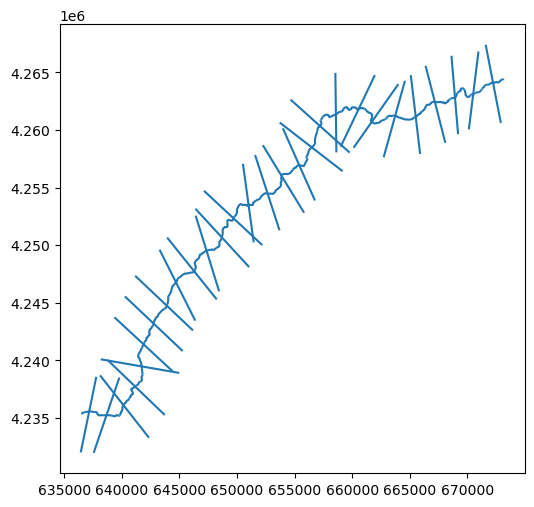

In [14]:
transg = gpd.GeoDataFrame(transects)
transg = transg.drop_duplicates('geometry')
transg['line'] = np.arange(0,len(transg))
transg.crs = 'epsg:32610'
# save to shapefile for reference
transg.to_file(gis_dir+'/transect_lines.shp')
# check cross section lines are paralle
fig,ax=plt.subplots(figsize=(6,6))
transg.plot(ax=ax)
cr.plot(ax=ax)


In [15]:
# # how often to interpolate a point in a XS
dline = 10

xs_all = gpd.GeoDataFrame(pd.DataFrame(columns=['xs_num','dist_from_right_m','geometry']))


for j in np.arange(0,len(transg)):
    xs = gpd.GeoDataFrame(pd.DataFrame(np.zeros((int(xs_width/dline),2)), columns=['xs_num','dist_from_right_m']))
    xs['geometry'] = Point([(0,0)])
    xs['xs_num'] = j
    
    # pick one geometry at a time
    geom = transg.iloc[j].geometry

    # # # length of the LineString
    length = int(geom.length)
    # create discrete points for each lien
    for i, distance in enumerate(range(0, int(length), dline)):
        point = geom.interpolate(distance)
        xs.loc[i,'geometry'] = point
        xs.loc[i,'dist_from_right_m'] = i
    # append individual cross section to all dataframe
    xs_all = xs_all.append(xs)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51496\3451959197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append(xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51496\3451959197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append(xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51496\3451959197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append(xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51496\3451959197.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append(xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51496\3451959197.py:2

Sample DEM for every XS point for an elevation

In [16]:

src = rasterio.open(raster_name)
xmin, xmax = src.bounds[0], src.bounds[2]
ymin, ymax = src.bounds[1], src.bounds[3]
 
xs_all.crs='epsg:32610'
xs_all['Easting'] = xs_all.geometry.x
xs_all['Northing'] = xs_all.geometry.y
# filter to points that truly overlap the DEM
xs_all = xs_all.cx[xmin:xmax, ymin:ymax]

# point = xs_all.loc[:,['Easting','Northing']].values # old
point = list(zip(xs_all.geometry.x, xs_all.geometry.y)) # same error

print(os.path.basename(raster_name))
with rasterio.open(raster_name) as src:
    xs_all['z_m'] = [sample[0] for sample in list(src.sample(point))]

# convert distance from right from 1/10 of meters because points were every 10 meters
# the distance was set with the index but really it should be 3200 meters not just 320 meters
xs_all.dist_from_right_m *= 10


modeldomain_10m_transformed.tif


## XS Cleaning
There isn't going to be a clear way to distinguish the levees and the XS shows bumpiness. The best solution will be to assume that levee setback will involve a cut and fill approach such that the ground surface elevation after setback is the mean of the elevation from before, but then this won't allow variable flooding based on elevation...

It will take looking at the XS in different regions.
It might be doable to fill in the channel as Sierra suggested which would raise the river above the levee and then install new "levee walls" at the desired distance. Filling in just the channel requires: 1. Going to the center line 2. go out some distance to account for channel width 3. set those values as a fraction of the levee height to insure more overbank flooding

In [18]:
# remove any NA values picked up from DEM raster
xs_all.loc[xs_all['z_m'] == xs_all.z_m.min(), ['z_m']] = np.nan
xs_all.index = np.arange(0,len(xs_all))
xs_all.drop(['geometry'],axis=1).to_csv(chan_dir+'XS_point_elevations.csv')

# convert to dataframe for easier plotting
xs_all_df = pd.DataFrame(xs_all)
# pivot based on XS number and save only elevation in z_m
xs_all_df = xs_all_df.pivot_table(index='dist_from_right_m',columns='xs_num',values='z_m')
xs_all_df.to_csv(chan_dir+'Elevation_by_XS_number_meters.csv')

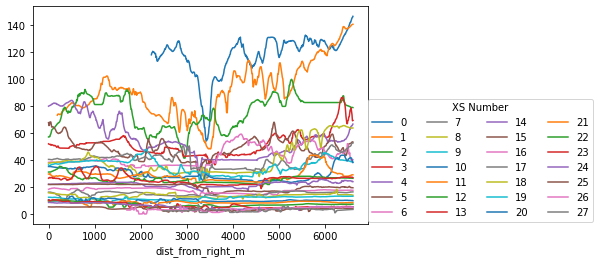

In [346]:

xs_all_df.plot()
plt.legend(ncol=4, loc=(1,0.01), title='XS Number')


The process will be too complicated too directly edit the raster, so individual cross-sections will be edited by applying a rolling mean in the floodplain in the 200-400 m around the main channel to "flatten" any levee like structure. Then new 'levee walls' will be placed at the desired setback distance.

Helen suggested looking at the historical 100 year flood to estimate the levee height they would have designed for, or look at the physical characteristics to design it. Levee construction began in 1930s, biggest flood was in 1907 at 71,000 cfs (estiamted) with a gage height of 16 ft at Michigan Bar so levee's would most likely be designed to at least 16 ft.

For each levee setback we should imagine that the channel is partially filled in, but rather than uniformly removing all levee walls within the floodplain, we breach the levee wall in 200 m sections for every 2km to allow flood water to inundate the floodplain and then new levees are constructed at the specified distance to bring ground level to 16 ft above channel bottom. In real life this height could probably be steadily lowered as there is so much room in the floodplain to accomdate the volume that a lower levee height suffices.
1. Rolling mean is used to fill in channel with earth from levee or nearby.
2. New levees are continuously installed at specified distance


It doesn't look like I will see much floodplain inundation, but I won't know until I estimate depth. Start with 2-3,000 is 1 year flood and 20,000 cfs is 5 year. The floodplain connection flow is estimated to be 2-3,000 cfs by Whipple in one paper on floodplain inundation at Oneto-Denier, and as 23 cms or 800 cfs in the flood typology paper.

In [24]:
xs_all = pd.read_csv(chan_dir+'XS_point_elevations.csv')

xs_all_df = pd.read_csv(chan_dir+'Elevation_by_XS_number_meters.csv',index_col='dist_from_right_m')

In [97]:
# 40 observations is equal to 400 meters
roll_window = 400

xs_levee_smooth = xs_all_df.copy()
xs_roll_mean = xs_all_df.rolling(int(roll_window/10), center=True).mean()
channel_middle = int(len(xs_all_df)/2)*10
channel_bool = (xs_all_df.index >= channel_middle - (roll_window/2))& (xs_all_df.index <= channel_middle + (roll_window/2))
xs_levee_smooth.loc[channel_bool,:] = xs_roll_mean.loc[channel_bool,:]
# save for flow-recharge notebook
xs_levee_smooth.to_csv(chan_dir+'xs_levee_smooth.csv')



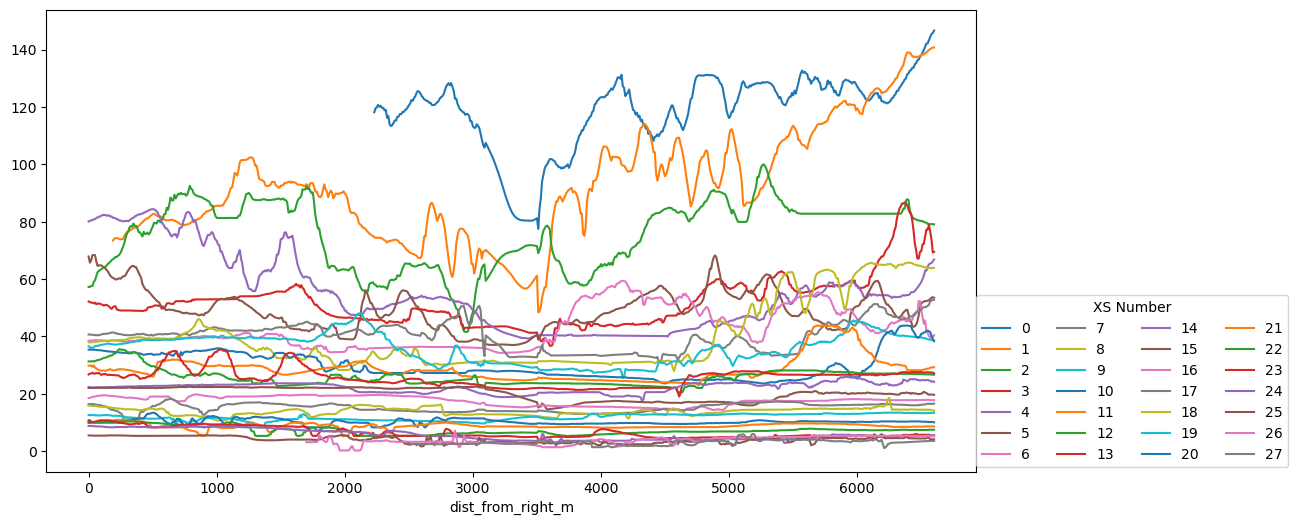

In [98]:
fig,ax = plt.subplots(figsize=(12,6))

xs_levee_smooth.plot(ax=ax)
ax.legend(ncol=4, loc=(1,0.01), title='XS Number')


## How to update XS to include changes in levees
The goal here is to provide a more physical representation of XS that just stopping the XS calculation in Manning's. Here the wetted perimiter of the channel would be larger at deeper depths.

This was implemented as a function called xs_setback

<AxesSubplot: xlabel='dist_from_right_m'>

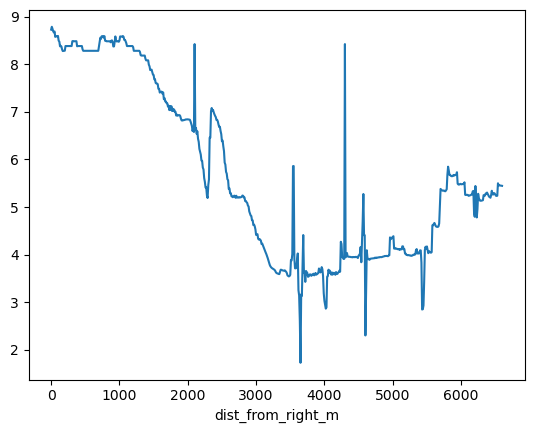

In [38]:
xs_test = xs_levee_smooth.copy()
# rather than saving a version of the xs for each setback just add this adjustment
n=5
# the channel should fall within the center 400m so that minimum can be used to set new levee height
thalweg = xs_test.loc[channel_middle-roll_window/2:channel_middle+roll_window/2].min()
# check to see XS elevation at setback distance to determine if it should be raised to needed levee height
levee_diff = xs_test.loc[3100-setbacks[n],:] - thalweg
# where XS height is less than 20 ft above channel bottom then raise to 20 ft above
xs_test.loc[3100-setbacks[n],:][levee_diff< 20*0.3048] = thalweg + 16*0.3048
levee_diff = xs_test.loc[3300+setbacks[n],:] - thalweg
xs_test.loc[3300+setbacks[n],:][levee_diff< 20*0.3048] = thalweg + 16*0.3048

xs_test.iloc[:,24].plot()


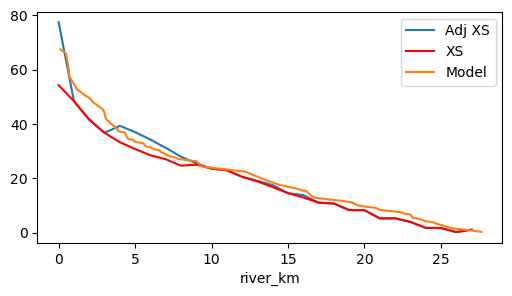

In [39]:
fig,ax=plt.subplots(figsize=(6,3))
xs_levee_smooth.min().plot(ax=ax, label='Adj XS')
xs_all_df.min().plot(ax=ax, color='red',label='XS')
grid_sfr.assign(river_km = np.cumsum(grid_sfr.length_m/dline_long)).plot(x='river_km',y='z',kind='line',ax=ax, label='Model')
plt.legend()

In [25]:
# dem data for cropping above land surface
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_linear.tsv')

# Mannings equation
The assumption of levee setback is that as the setback distance increases so does the wetted xs perimeter which increases the hydraulic radius (there is more roughness impacting the water) so the velocity will be lower. This analysis is independent of varying geology, and river reach under the assumption that any recontoured reach would undergo restoration resulting in similar reach rougnesses of the floodplain (small bushes, trees). And it will assume the existing average bed slope of the lower Cosumnes river applies.  
This analysis could be done by running a HEC-RAS model at all of these different setback distances, but here the goal is to determine the trend and general distance at which diminishing returns occur.  The analysis will be completed first for a typical winter flood event of 2,000 cfs which is near floodplain connectivity (need to approximate area and velocity of channel as starting point or else will need to cycle through several areas/wetted perimeters - better to just use multiple areas that connect to multiple possibles flood sizes )  
The width will range from 0 to 3200 meters in both direction but I coud have depth be dependent on the actual elevations  
Manning Equation for SI units  
$ Q = VA = (\frac{1.00}{n}) A  {R}^{2/3} \sqrt{S} $  
$ R = \frac{A}{Wp}$  
hydraulic radius r is XS area divided by wetted perimeter  
[Manning's eqn reference](http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Manning_s_Equation.htm)  
Avg manning's n for in channel is 0.048  - clean, winding, some pools and shoals, but some weeds and stones, lower stages, more ineffective, slopes and sections
Floodplains have much broader range, due to variability in vegetation type: tall grass is 0.035 but dense willows is 0.15  
[Manning's n reference](http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm)  

Slope for Cosumnes could be considered the 0.0006 which is the mean for all reaches

In [40]:
fxn_dir = git_dir+'/python_utilities'
if fxn_dir not in sys.path:
    sys.path.append(fxn_dir)
# sys.path
# import muskingum_recharge as mr

from importlib import reload
# reload(mr)

In [142]:
from muskingum_recharge import min_Q, mannings, calc_depth_arr, gridded_interpolation, xs_setback, mannings_v


In [43]:
# grid x,y coords for interpolation output
# x_out = grid_p.geometry.centroid.x.values
# y_out = grid_p.geometry.centroid.y.values



## Return period floods (5, 20, 50,100 yr)

peak_dt  return-period  Discharge (cfs)
70   1977-02-22           1.01              202
67   1974-03-02           1.98             8980
62   1969-01-21           5.00            22500
2    1909-01-13           9.58            28400
58   1964-12-23          19.17            37500
110  2017-02-10          57.50            49700
90   1997-01-02         115.00            93000

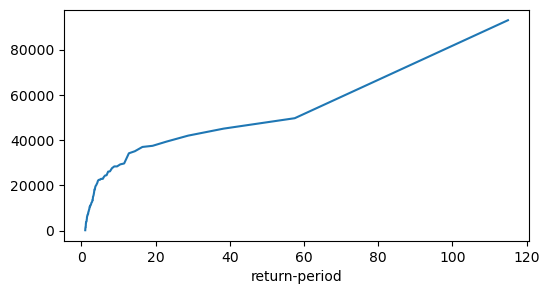

In [44]:
peak_flows = pd.read_csv(box_dir+'michigan_bar_peak_flows.tsv', delimiter='\t', comment='#')
peak_flows = peak_flows.drop(0)
peak_flows = peak_flows.dropna(subset=['peak_va'])
peak_flows = peak_flows[['peak_dt','peak_va','gage_ht']]
peak_flows.peak_va = pd.to_numeric(peak_flows.peak_va)
annual_max_df_sorted = peak_flows.sort_values('peak_va', ascending=True)

# code from hydro-informatics exercsises
n = annual_max_df_sorted.shape[0]
annual_max_df_sorted.insert(0, "rank", range(1, 1 + n))
annual_max_df_sorted["pr"] = (n - annual_max_df_sorted["rank"] + 1) / (n + 1)
annual_max_df_sorted["return-period"] = 1 / annual_max_df_sorted["pr"]
annual_max_df_sorted["period_int"] = annual_max_df_sorted["return-period"].astype(int)

# annual_max_df_sorted[annual_max_df_sorted.period_int==50]

# identify relevant return period flows
per_id = []
for per in [1,2, 5, 10, 20, 50, 100]:
    per_id = per_id + [np.argmin(np.abs((annual_max_df_sorted['return-period']-per).values))]
per_table = annual_max_df_sorted.iloc[per_id][['peak_dt','return-period','peak_va']].round(2)
per_table = per_table.rename(columns={'peak_va':'Discharge (cfs)'})

annual_max_df_sorted.plot(x='return-period',y='peak_va', figsize=(6,3), legend=False)

display(per_table)

In [29]:
# from scipy.optimize import fsolve, least_squares, minimize, minimize_scalar

# fsolve(mannings, [2], args = (Q_cms, xs_elevs), xtol=1E-5)
# least_squares(mannings, [2], args = (Q_cms, xs_elevs), bounds = (0, 10), ftol=1E-5)
# minimize(mannings, [1.], args = (Q_cms, xs_elevs), bounds=[(0,10)], tol=1E-5)

# # res = minimize_scalar(mannings,  args = (Q_cms, xs_elevs), bounds=(0,10), method='bounded')
# res

In [45]:
# wse_grid = gpd.sjoin(xs_all, grid_p, how='left', op='within')
# # wse_grid = gpd.sjoin(grid_p, wse_interp,  how='left', op='overlaps')

# print(wse_grid.node.isna().sum(), 'nodes are NAs when joining grid, most likely due to values near top of domain')
# wse_grid = wse_grid.dropna(subset=['node'])

# # wse_grid_first = wse_grid.dissolve('xs_num','mean')
# # wse_grid_first['dem_200_z_m'] = dem_data[(wse_grid_first.row-1).astype(int), (wse_grid_first.column-1).astype(int)]
# wse_grid['dem_200_z_m'] = dem_data[(wse_grid.row-1).astype(int), (wse_grid.column-1).astype(int)]


In [31]:
# wse_grid.to_file(gis_dir+'wse_grid.shp')


In [46]:

# def calc_depth_arr(wse_grid, wse_all):
#     # summarize to model grid nodes
#     grid_wse_mean = wse_grid.join(wse_all, on='xs_num')
#     grid_wse_mean = grid_wse_mean.dissolve(by = 'node',aggfunc='mean')

#     # interpolate flood water surface and elevation from cross-section data
#     wse_arr = gridded_interpolation(grid_wse_mean.wse_m, grid_wse_mean.geometry.centroid.x, grid_wse_mean.geometry.centroid.y)
#     z_arr = gridded_interpolation(grid_wse_mean.z_m, grid_wse_mean.geometry.centroid.x, grid_wse_mean.geometry.centroid.y)
#     # flood depth is difference between flood water surface elevation and cross-section elevation
#     d_arr = wse_arr-z_arr
#     d_arr[d_arr<0] = np.NaN
#     # remove data outside of setback
#     d_arr[str_setbacks[s] !=1] = np.NaN
#     return(d_arr)
# xs_elev, wse_grid
# s = 1
# setback = setbacks[s]

# wse_all = pd.DataFrame(xs_levee_smooth[3100-setback:3300+setback].min()+depths[s,:], columns=['wse_m'], dtype='float64')
# d_arr = calc_depth_arr(wse_grid, wse_all)
# # np.savetxt(box_dir+'channel_data/'+str(setback)+'setback_depth_array_'+str(Q_cfs)+'cfs.tsv', d_arr, delimiter='\t')


# Iterate across all levee setbacks here
Checking issue where inundated area seems to decrease in some areas when setback is increased. it's okay for inundated area to decrease because when setback increases the depth is decreased and so there will be some cells that are now above the flood

In [47]:
mb_daily = pd.read_csv(gwfm_dir+'/SFR_data/MB_daily_flow_cfs_2010_2019.csv').dropna()

In [48]:
# mb_daily.plo/t(x='datetime',y='flow_cfs', legend=False)
# mb_daily[(mb_daily.flow_cfs > 20000)].plot(x='datetime',y='flow_cfs')

In [49]:
# cms to cmh sustained for about 0.6 hour based on how long flood wave travels 2 km
# 
# total_vol = 40*60*60*0.6
total_vol = 40*60*60*24*7 # if flow occurred for 7 days

# calculate area for setbacks
max_area = str_setbacks[-1,:,:].sum()*200*200
# area from high flow cells within 3000m setback
max_area = 16640000.0

# even if we had that recharge rate for a full week, theoretically we only recharge 0.07 m of water
# if we limit the recharge volume to only those local cells then we would only see 1.45 m distributed

total_vol/max_area

1.4538461538461538

Text(0, 0.5, 'Flow (cms)')

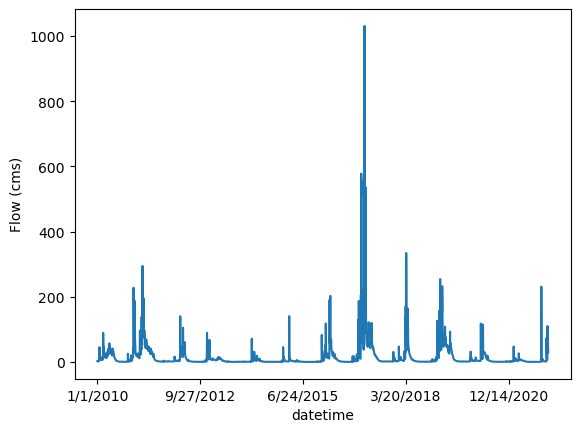

In [50]:
mb_daily['flow_cms'] = mb_daily.flow_cfs * (0.3048**3)
mb_daily.plot(x='datetime',y='flow_cms', legend=False)
plt.ylabel('Flow (cms)')

In [34]:
# n=3
# mb_daily[mb_daily.flow_cfs > per_table['Discharge (cfs)'].iloc[n]]
# mb_daily[mb_daily.flow_cfs > 2000]

In [51]:
# Q_cfs = 93000 #  115 year
# Q_cfs = 39400 # 23 year return period
Q_cfs = 22500 # 5 year
# Q_cfs = 2000 # 1ish year

Q_cms = Q_cfs*(0.3048**3) # convert to cubic meters per second



 will need to iterative solve for Area, area is the sum of area between depth and ground surface
 
 As we iterate down the XS we need to account for water lost to recharge

In [52]:
# find minimum from channel center
xs_mins = xs_levee_smooth.loc[3100:3300].min(axis=0)
xs_mins.index = xs_mins.index.astype(int)
# xs_mins.interpolate(method='linear').plot()
slope = xs_mins.diff().rolling(2, center=True, closed='right').mean().bfill()/2000*-1
adj_xs_mins = np.append(xs_mins[0], (xs_mins[0]-slope.cumsum()*2000))


In [276]:
nseg = 20
setback = 8*200
xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg].copy(), setback, 30)

def depth_match(xs_elevs, nseg, setback):
    """ For a XS find the depth that best matches the flow given with stepwise global sampling"""
    q_test = 0
    dec = 10
    di=1
    df = 1E-6
    # 3 decimal places is enough to be within 1 cms
    for dec in [10, 1, 0.1, 0.01]:
        # set range of values to test above last value if too low or below if too high
        if q_test < Q_cms:
            d_test = np.arange(df, df + dec, dec/10)
        else:
            d_test = np.arange(df - dec, df, dec/10)
        # calculate flow for depth range
        q_test = [mannings([d], xs_elevs, n, slope.iloc[nseg]) for d in d_test]
        print(df,q_test)
        # find depth with minimum error
        di = np.argmin(np.abs(np.subtract(q_test, Q_cms)))
        q_test = q_test[di]
        # add the decimal place to the depth
        df += np.copy(di)*dec/10
    return(df)

d_out = depth_match(xs_elevs, nseg, setback)
d_out, mannings([d_out], xs_elevs, n, slope.iloc[nseg])

1e-06 [inf, 0.6897144176733124, 5.751940344364833, 25.431456106240244, 61.50292275346614, 110.38358504495517, 170.04328699942553, 239.5762122203906, 318.3219686158702, 405.7682517234287]
9.000001 [405.7682517234287, 414.97479043600885, 424.2637656821788, 433.63481326545354, 443.08757534134276, 452.6217002259714, 462.23684221283196, 471.932661397228, 481.7088235079904, 491.56499974608397]
9.900001 [491.56499974608437, 492.55500564759666, 493.5458081306977, 494.53740687530006, 495.52980156183037, 496.52299187122645, 497.5169774849379, 498.5117580849239, 499.50733335365186, 500.50370297409563]
9.990001 [500.50370297409563, 500.60338361329354, 500.70307219252743, 500.80276871148027, 500.90247316983573, 501.0021855672778, 501.1019059034913, 501.2016341781598, 501.30137039096644, 501.40111454159626]


(9.999001, 501.4011145415971)

In [373]:
from scipy.optimize import minimize_scalar, minimize
from scipy.optimize import basinhopping

n= 0.048

# setback = 3000
# depths = np.zeros(xs_levee_smooth.shape[1])
depths = np.zeros((len(setbacks), xs_levee_smooth.shape[1]))
q_check = np.zeros(depths.shape)

# iterate across all setbacks
for nseg in np.arange(0, xs_levee_smooth.shape[1]): #xs_levee_smooth.shape[1]
    # setbacks don't go past 3000, enumerate includes 3200 which we don't want
    for s,setback in enumerate(setbacks): 
        # for a given setback imagine there is an impenetrable levee blocking overbank flow
#         xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
        xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg].copy(), setback)
    
        # solve for depth that matches given flow
        res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q_cms), 
                                  bounds=(0.1,10), method='Golden', tol=1E-3)
        if res.fun>0.05*Q_cms: # greater than 5% difference try to fix with bounded solving
            print(str(nseg),' ', s, '%.2f'%res.fun, 'iter %i'%res.nit, ', ',res.success, 'd %.2f'%res.x)
        if mannings(res.x, xs_elevs, n, slope.iloc[nseg]) > Q_cms*1.05:
            res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q_cms), 
                          bounds=(0.1,res.x-0.1), method='bounded', tol=1E-3)
        if mannings(res.x, xs_elevs, n, slope.iloc[nseg]) < Q_cms*0.95:
            res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q_cms), 
                          bounds=(res.x+0.1,10), method='bounded', tol=1E-3)
        # changing tolerance doesn't improve function error
        depths[s, nseg] = res.x
#         depths[s,nseg] = depth_match(xs_elevs, nseg, setback)
        q_check[s,nseg] = mannings(depths[s,nseg], xs_elevs, n, slope.iloc[nseg])

6   4 146.27 iter 14 ,  True d 1.85
6   5 215.03 iter 14 ,  True d 1.64
10   6 71.88 iter 14 ,  True d 3.61
15   8 413.94 iter 15 ,  True d 2.26


In [124]:
d_arr = np.zeros((len(setbacks),m.dis.nrow,m.dis.ncol))
for s,setback in enumerate(setbacks):
# s, setback = 2, 400
#     wse_all = pd.DataFrame(xs_levee_smooth[3100-setback:3300+setback].min()+depths[s,:], columns=['wse_m'])
    wse_all = pd.DataFrame(xs_levee_smooth.min()+depths[s,:], columns=['wse_m'])
    d_arr[s,:,:] = calc_depth_arr(wse_grid, wse_all)
    
d_arr_out = np.reshape(d_arr, (len(setbacks)*m.dis.nrow, m.dis.ncol))
np.savetxt(box_dir+'channel_data/depth_array_'+str(Q_cfs)+'cfs.tsv', d_arr_out, delimiter='\t')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py

In [608]:

# s1 = 1
# s2 = 2
# print('Flood cells matching in setback ',s1,' and ',s2,' :',((d_arr[s2,:]>0) &(d_arr[s1,:]>0)).sum(), 
#       'flood cells in setback ',s1,':', (d_arr[s1,:]>0).sum())
# # plt.imshow(d_arr[1,:])
# # plt.show()
# plt.imshow(d_arr[s1,:])
# plt.show()
# plt.imshow(d_arr[s2,:])
# plt.show()
# plt.imshow(d_arr[s1,:]*((d_arr[s2,:]>0) &(d_arr[s1,:]>0)))

In [379]:
V_arr = np.zeros((len(setbacks), xs_levee_smooth.shape[1]))
for s,setback in enumerate(setbacks):
    for nseg in np.arange(0,xs_levee_smooth.shape[1]):
        # for a given setback imagine there is an impenetrable levee blocking overbank flow
        xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg].copy(), setback, 30)
        # solve for depth that matches given flow
        V_arr[s, nseg] = mannings_v(depths[s, nseg], 0, xs_elevs) # output is Q_calc - Q so if Q=0 then output is Q_calc


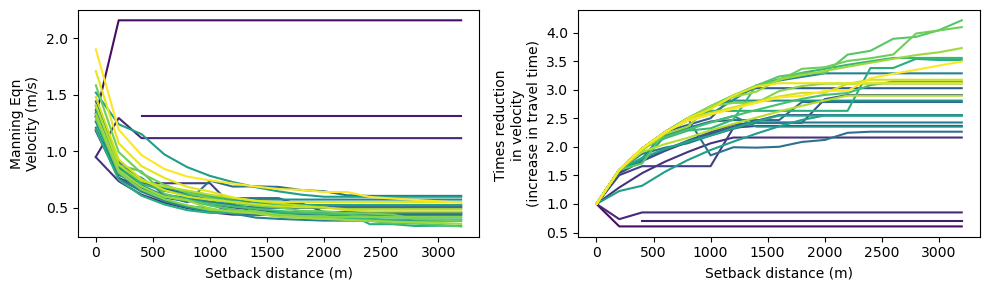

In [380]:
fig,ax = plt.subplots(1,2, figsize=(10,3))
ax_n= ax[0]
pd.DataFrame(V_arr,index=setbacks).plot(cmap='viridis', legend=False, ax = ax_n)
ax_n.set_xlabel('Setback distance (m)')
ax_n.set_ylabel('Manning Eqn\nVelocity (m/s)')

ax_n= ax[1]
pd.DataFrame(V_arr[0,:]/V_arr,index=setbacks).plot(cmap='viridis', legend=False, ax = ax_n)
ax_n.set_xlabel('Setback distance (m)')
ax_n.set_ylabel('Times reduction \nin velocity \n(increase in travel time)')

fig.tight_layout()

 0.00024 is the slope which matches the mean slope of the streambed


Text(0, 0.5, 'Depth (m)')

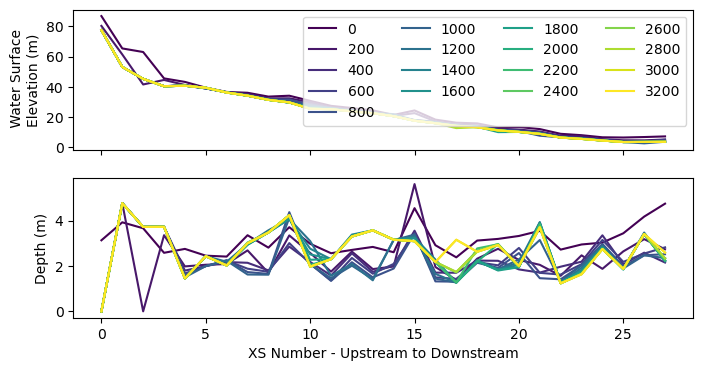

In [381]:
fig,ax=plt.subplots(2,1, figsize=(8,4),sharex=True)
ax_n = ax[0]
wse_plt = np.zeros(depths.shape)
for s,setback in enumerate(setbacks):
    wse_plt[s,:] = (xs_levee_smooth[3100-setback:3300+setback].min()+depths[s,:])
#     (xs_levee_smooth[3100-setback:3300+setback].min()+depths[s,:]).plot(ax=ax_n,  label=setback)

pd.DataFrame(wse_plt,index=setbacks).transpose().plot(cmap='viridis',legend=False, ax = ax_n)

# ax_n.plot(xs_levee_smooth.min()+depths)
# ax_n.set_xlabel('XS Number - Upstream to Downstream')
ax_n.set_ylabel(' Water Surface\nElevation (m)')
ax_n.legend(ncol=4)

print(' %.5F is the slope' % (15/(62*1000)), 'which matches the mean slope of the streambed')

ax_n = ax[1]
# ax_n.plot(depths)
pd.DataFrame(depths,index=setbacks).transpose().plot(cmap='viridis',legend=False, ax = ax_n)

# for s,setback in enumerate(setbacks):
#     ax_n.plot(depths[s,:], cmap='magma')
ax_n.set_xlabel('XS Number - Upstream to Downstream')
ax_n.set_ylabel('Depth (m)')

# plt.savefig(fig_dir+ 'water surface elevation-depth profile (m) at' + str(Q_cfs)+'cfs.png')


XS 0 area: 559.94 m^2,V 1.40 Q 786.10
XS 400 area: 958.80 m^2,V 0.82 Q 786.56
XS 800 area: 1377.94 m^2,V 0.57 Q 786.01
XS 1200 area: 1625.12 m^2,V 0.48 Q 786.66
XS 1600 area: 1808.85 m^2,V 0.43 Q 785.44
XS 2000 area: 1841.63 m^2,V 0.43 Q 786.21
XS 2400 area: 2061.36 m^2,V 0.38 Q 786.11
XS 2800 area: 2199.94 m^2,V 0.36 Q 786.74
XS 3200 area: 2361.58 m^2,V 0.33 Q 786.48


Text(0.4, -0.03, 'Distance from right (m)')

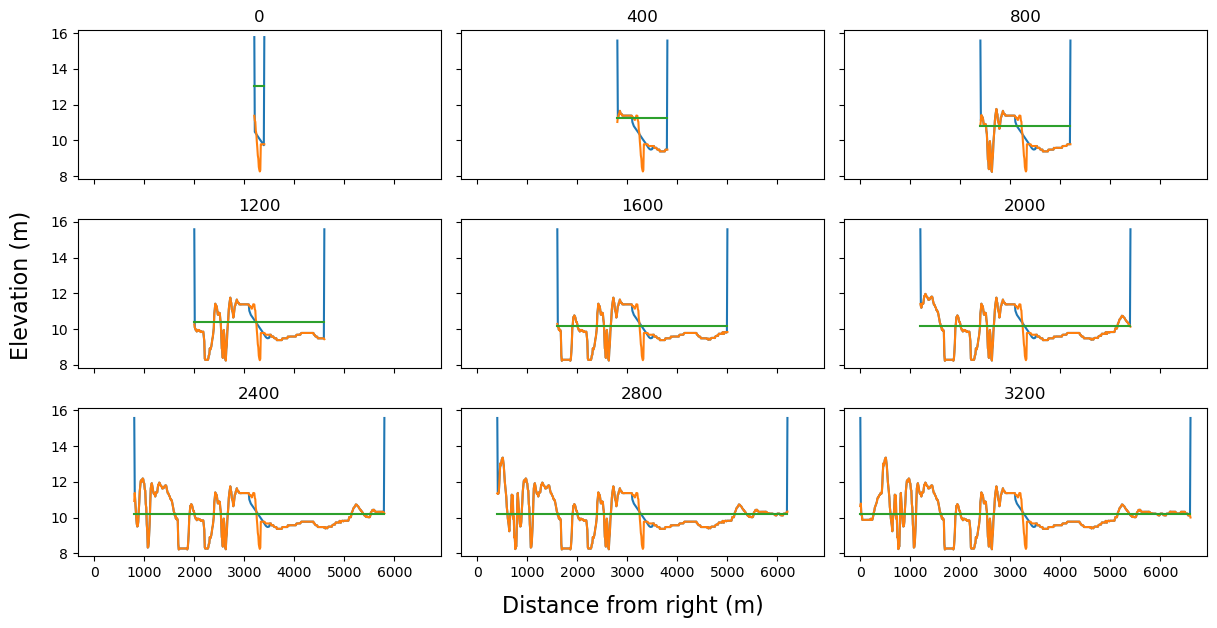

In [388]:
# plot different setback XS for middle segment
plt_xs = np.arange(0,setbacks.shape[0],2)
ny = 3
nx = int(np.ceil(plt_xs.shape[0]/ny))

fig,ax = plt.subplots(nx,ny, figsize=(ny*4,nx*2),sharex=True, sharey=True)

nxs = int(xs_levee_smooth.shape[1]/2)
nxs= 20

for n, s in enumerate(plt_xs):
    setback = setbacks[s]
    ax_n = ax[int(n / ny), n % ny] if (nx > 1) else ax[i]
    xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nxs].copy(), setback=setback)
    # plot levee setback adjusted XS
    xs_elevs.plot(ax=ax_n)
    # plot original cross-section    
    mid = np.mean(xs_levee_smooth.index) # location that should be channel bottom based on NHD line

    xs_all_df.iloc[:,nxs][mid-100-setback:mid+100+setback].plot(ax=ax_n)
    depths_plt = depths[s,:]
    ws = xs_elevs.min() +depths_plt[nxs]
    ax_n.plot([mid-100-setback, mid+100+setback],[ws,ws], label='setback')

    ax_n.set_title(str(setback))#+' , '+ str(np.round(ws,2))
    ax_n.set_xlabel('')
    xs_A = (ws - xs_elevs)[(ws - xs_elevs)>0].sum()*10
    print('XS '+str(setback)+' area: %.2f' %xs_A, 'm^2',end=',')
    print('V %.2f' %V_arr[s, nxs], 'Q %.2f' %(V_arr[s,nxs]*xs_A) )
#         n+=1

fig.tight_layout()
fig.text(-0.01, 0.4, 'Elevation (m)', rotation=90, size=16)
fig.text(0.4, -0.03, 'Distance from right (m)', size=16)

# plt.savefig(fig_dir +str(setback)+'setback_XS_with_depth_' +str(Q_cfs)+ 'cfs.png')

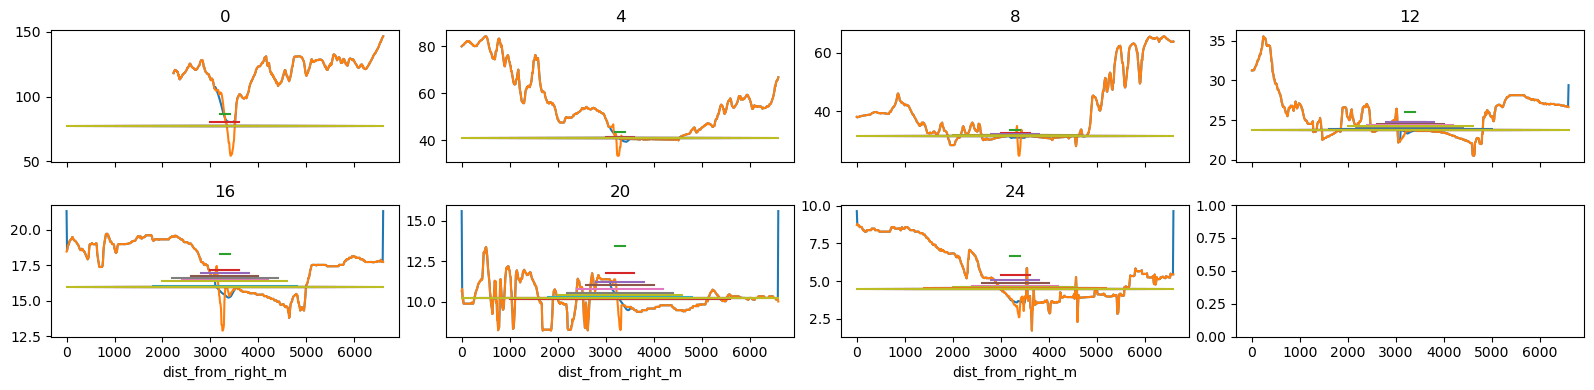

In [383]:
# depths_plt = depths[0,:]

# nx,ny = 12,5
plt_xs = np.arange(0,xs_levee_smooth.shape[1],4)
ny = 4
nx = int(np.ceil(plt_xs.shape[0]/ny))
setback = 3200
s=16
fig,ax = plt.subplots(nx,ny, figsize=(ny*4,nx*2),sharex=True, sharey=False)
n=0
for n,nxs in enumerate(plt_xs):
# for i in np.arange(0,nx):
#     for j in np.arange(0,ny):
#         ax_n = ax[i,j]
    ax_n = ax[int(n / ny), n % ny] if (nx > 1) else ax[i]
    xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nxs].copy(), setback=setback)
    xs_elevs.plot(ax=ax_n)    
    mid = np.mean(xs_levee_smooth.index) # location that should be channel bottom based on NHD line
    xs_all_df.iloc[:,nxs][mid-100-setback:mid+100+setback].plot(ax=ax_n)
    for s,setback in enumerate(setbacks):
        depths_plt = depths[s,:]
        ws = xs_levee_smooth.iloc[:,nxs][3100-setback:3300+setback].min() +depths_plt[nxs]
        ax_n.plot([mid-100-setback, mid+100+setback],[ws,ws], label='setback')

    ax_n.set_title(nxs)
#         n+=1
fig.tight_layout()
# plt.savefig(fig_dir +str(setback)+'setback_XS_with_depth_' +str(Q_cfs)+ 'cfs.png')